### 목표
- 타이타닐 데이터를 모델에 학습시켜서 생존/사망 예측
- 머신러닝의 전체 과정을 진행해보자

#### 1. 문제정의
- Kaggle에서 제공하는 titanic 데이터를 사용해서 승객의 생존 여부를 예측
- 지도 학습
- Survived 컬럼의 데이터값은 수치형이지만, (0,1) 생존 여부만 구분하고 있기 때문에 우선순위는 없음
- 분류

In [566]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns # 시각화 도구

#### 2. 데이터 수집
- 타이타익 train 데이터와 test데이터를 변수 train, test에 저장

In [568]:
train = pd.read_csv('data/train (1).csv', index_col = 'PassengerId')
test = pd.read_csv('data/test (1).csv', index_col = 'PassengerId')

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [569]:
# 크기 확인
print(train.shape)
print(test.shape)

(891, 11)
(418, 10)


#### 3. 데이터 전처리 및 데이터 탐색

In [571]:
# 훈련 데이터 셋 정보 확인
train.info()
# 결측치가 있음 ( Age, Cabin, Embarked )
# 문자 > 숫자 : 인코딩

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [572]:
test.info()
# 정답 데이터 (Survived) 없음
# 결측치 존재 (Age, Fare, Cabin)
# 필요시 인코딩

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [573]:
# 컬럼 정보 정리
train.columns
'''
Pclass : 객실 등급 (1:상위층, 2: 중상위, 3:하위층)
Name : 이름
Sex : 성별
Age : 나이
SibSp : 형제자매/배우자(같이 탑승한)
Parch : 부모/자식(같이 탑승한)
Ticket : 티켓 번호
Fare : 요금
Cabin : 객실 번호
Embarked : 승선항 (S, C, Q)
'''

'\nPclass : 객실 등급 (1:상위층, 2: 중상위, 3:하위층)\nName : 이름\nSex : 성별\nAge : 나이\nSibSp : 형제자매/배우자(같이 탑승한)\nParch : 부모/자식(같이 탑승한)\nTicket : 티켓 번호\nFare : 요금\nCabin : 객실 번호\nEmbarked : 승선항 (S, C, Q)\n'

#### 결측치 채우기
- train : Age, Cabin, Embarked
- test : Age, Fare, Cabin

In [575]:
# 결측치를 채우는 방법
# 1. 결측치가 있는 행 전체를 삭제하는 방법 > 삭제하는 데이터가 너무 많거나, 모델링에 치명적이지 않은 데이터이어야 함..
# 데이터가 많을수록 과대적합을 피할 수 있음. > 삭제시 데이터 양이 줄어들기 때문.

# 2. 결측치를 다른 값(대표 값)으로 대체하는 방법
# > 평균, 최빈값, 중앙값

- train - Embarked 컬럼 결측치 채우기

In [577]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [578]:
# Embarked 컬럼의 결측치는?
train['Embarked'].isnull().sum()

2

In [579]:
# 결측치가 있는 데이터 출력 ( 불리언 인덱싱 )
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [580]:
# fillna('값')
# 비어있는 데이터가 있다면, '값'으로 채워주는 함수
train['Embarked'] = train['Embarked'].fillna('S')

In [581]:
train['Embarked'].isnull().sum()

0

- test : Fare 컬럼의 결측치 채우기

In [583]:
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [584]:
# 상관관계 확인
test.corr(numeric_only=True) # 숫자 컬럼 포함
# 상관 계수 : -1 ~ 1 범위로 표현됨
# -1, 1에 가까울수록 해당 컬럼과의 상관관계가 높다.
# 0 에 가까울수록 상관관계가 낮다.

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,-0.577147,0.337932,0.171539,0.230046,1.000000


In [585]:
train.corr(numeric_only=True)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


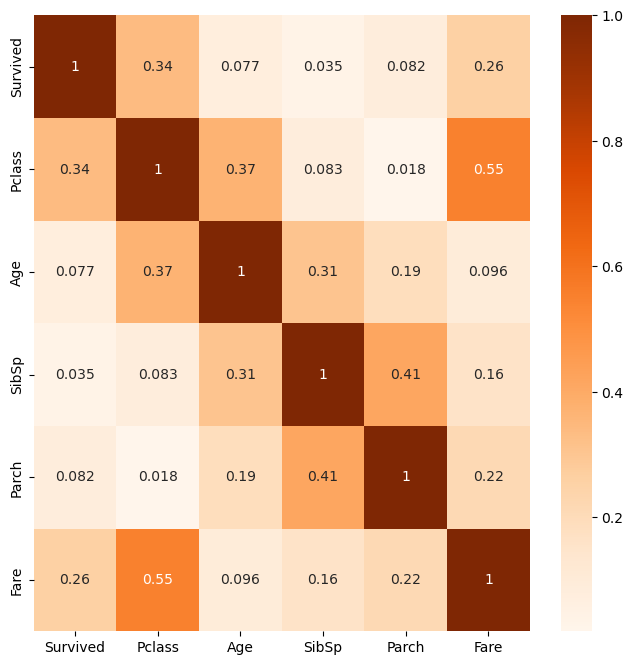

In [586]:
# 히트맵 표현
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(numeric_only=True).abs(), annot = True, cmap = 'Oranges')
plt.show()

In [587]:
# train Pclass 컬럼
train['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [588]:
# 객실등급을 기준으로 그룹화 groupby(), 요금 컬럼 집계함수 중앙값 median()
train[['Pclass','Fare']].groupby('Pclass').median()

,Fare
Pclass,
1,60.2875
2,14.2500
3,8.0500


In [589]:
# Pclass, Sex를 기준으로 그룹핑하여 Fare의 중앙값을 확인
train[['Pclass','Sex','Fare']].groupby(['Pclass','Sex']).median()

Fare
Pclass Sex             
1      female  82.66455
       male    41.26250
2      female  22.00000
       male    13.00000
3      female  12.47500
       male     7.92500

In [590]:
# 결측치가 있는 행 확인
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [591]:
test['Fare'] = test['Fare'].fillna(7.925)

In [592]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


- train, test Age 채우기
- 위에서 사용했던 Pclass, Sex컬럼을 그룹핑해서 Age의 집계를 확인하고 채워보자

In [594]:
# 평균값을 쓸지, 중앙값을 쓸지 판단을 위해 Age컬럼의 기술통계량을 확인
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [595]:
# Age는 Pclass와 상관관계가 높았다.
# Pclass, Sex를 그룹핑하여 Age의 평균을 출력해보자

gb1 = train[['Pclass','Sex','Age']].groupby(['Pclass','Sex']).median()
gb1

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

In [596]:
# gb1 - index 2개 Pclass, Sex
# 멀티인덱스
# 2등석, 남성 : 평균 나이 
gb1.loc[(2,'male')]

Age    30.0
Name: (2, male), dtype: float64

In [597]:
# train Age 결측치가 있는 행 출력
train[train['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [598]:
gb1.loc[(2,'male')]

Age    30.0
Name: (2, male), dtype: float64

In [599]:
gb1

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

In [600]:
# 규칙에 맞게 Pclass와 Sex에 따른 Age값을 반환하는 함수 선언
def fill_age(row):
    # row = 받아오는 행의 데이터 (매개변수)

    # 만약에 Age 컬럼이 결측치라면, gb1 테이블의 값을 인덱싱
    if np.isnan(row['Age']):
        return gb1.loc[(row['Pclass'],row['Sex'])]
    # 결측치가 아니라면. 원래 값을 사용
    else:
        return row['Age']

In [601]:
train['Age'] = train.apply(fill_age, axis = 1).astype(np.int64)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


C:\Users\a\AppData\Local\Temp\ipykernel_11332\1285069644.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  train['Age'] = train.apply(fill_age, axis = 1).astype(np.int64)


In [602]:
test['Age'] = test.apply(fill_age, axis = 1).astype(np.int64)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


C:\Users\a\AppData\Local\Temp\ipykernel_11332\196377789.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  test['Age'] = test.apply(fill_age, axis = 1).astype(np.int64)


In [603]:
test['Age'].unique()

array([34, 47, 62, 27, 22, 14, 30, 26, 18, 21, 25, 46, 23, 63, 24, 35, 45,
       55,  9, 48, 50, 41, 33, 39, 40, 60, 36, 20, 28, 10, 17, 32, 13, 31,
       29,  6, 67, 49,  2, 76, 43, 16,  1, 12, 42, 53, 61,  7, 15, 54, 64,
       37, 11,  8,  0, 38, 57, 19, 58, 59, 44,  5, 51,  3], dtype=int64)

#### 정리
- apply, fill_age를 통해
- 테스트 데이터를 행단위로 쪼갠것을 매개변수로 안쪽 로직이 동작
- 결과값으로 Age를 채울 수 있는 대표값 반환
- 정수형으로 변환한 후 train,test 'Age'컬럼에 넣어주는 작업

- train, test Cabin 채우기
- Cabin 컬럼 데이터 확인
- 임의의 값으로 결측치 채울 예정

In [606]:
# train 기준으로 데이터 확인
train['Cabin'].unique()

# 타이타닉 호는 A, B, C 층으로 표기한다. > 알파벳만 뽑아서 사용.

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [607]:
# 임의의 값으로 train, test의 Cabin 결측치를 채워보자
# 'T'로 채워보자
train['Cabin'] = train['Cabin'].fillna('M')
test['Cabin'] = test['Cabin'].fillna('M')

In [608]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     891 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [609]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     418 non-null    object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [610]:
# 첫글자 알파벳 1개 추출하기
train['Deck'] = train['Cabin'].str[0]
# str : 데이터 내부 문자열 접근.
test['Deck'] = test['Cabin'].str[0]

# 확인
train.columns, test.columns

(Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
        'Fare', 'Cabin', 'Embarked', 'Deck'],
       dtype='object'),
 Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
        'Cabin', 'Embarked', 'Deck'],
       dtype='object'))

In [611]:
# Cabin 컬럼 삭제 .drop(컬럼명, axis = 0(행) or 1(열), inplace = True(바로 적용) or False(default. 미적용))

train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)



In [612]:
# 확인
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    i

- Deck 시각화

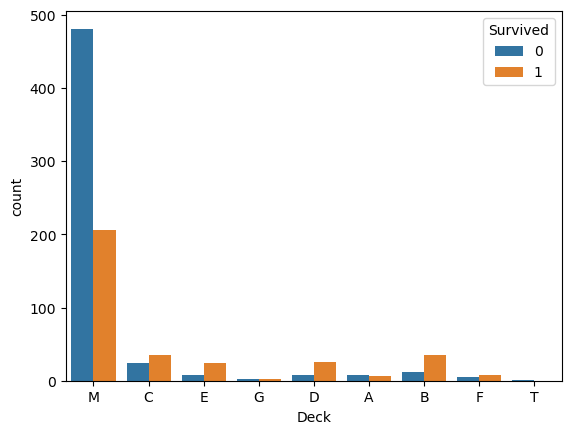

In [614]:
# sns 시각화 도구를 사용해서 범주형 데이터 Deck을 시각화 해보자
sns.countplot(data = train, x = 'Deck', hue = 'Survived')
# countplot : 갯수 시각화 (x : x축, hue : 분할 기준.나타내고자 하는 것)
plt.show()

In [615]:
# M층 : 결측치인 객실에서 사망률이 높다.

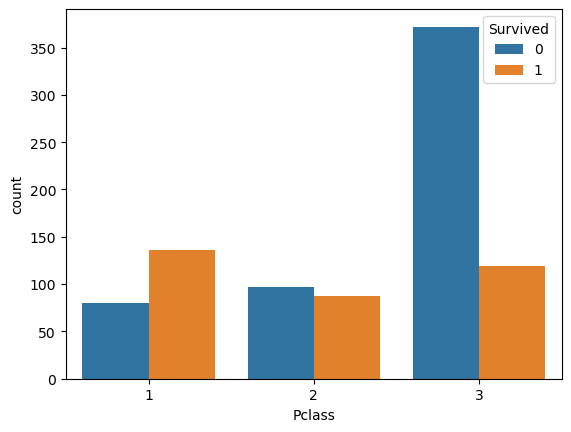

In [616]:
# Pclass가 사망에 얼마나 영향을 미쳤는지 시각화
sns.countplot(data = train, x = 'Pclass', hue = 'Survived')
plt.show()

- Deck과 Pclass 시각화

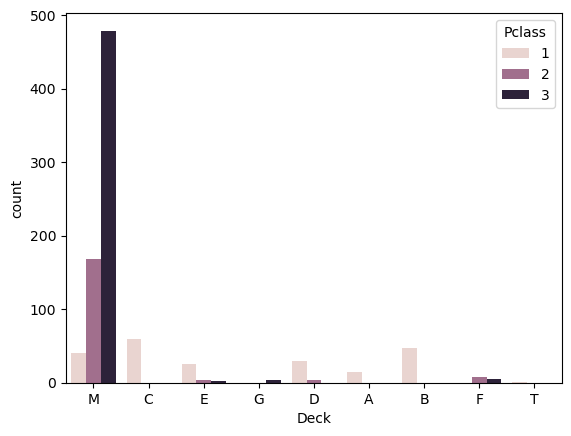

In [618]:
sns.countplot(data = train, x = 'Deck', hue = 'Pclass')
plt.show()

In [619]:
# M층은 3등급인 경우가 대부분임. 따라서 상대적으로 사망률이 높았다.
# M층인 경우 Pclass = 3

- 성별에 따른 생존/사막 시각화

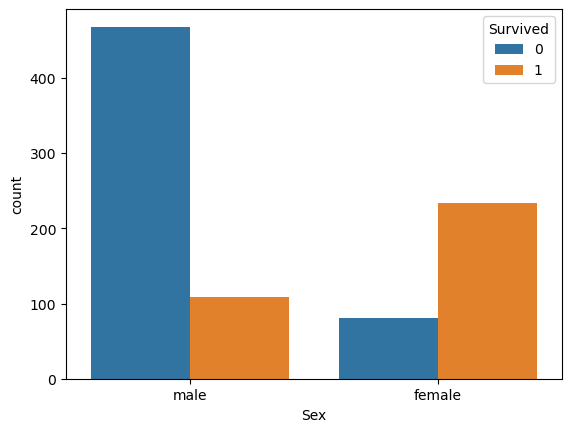

In [621]:
sns.countplot(data = train, x = 'Sex', hue = 'Survived')
plt.show()

- 승선항과 생존/사망 여부 시각화

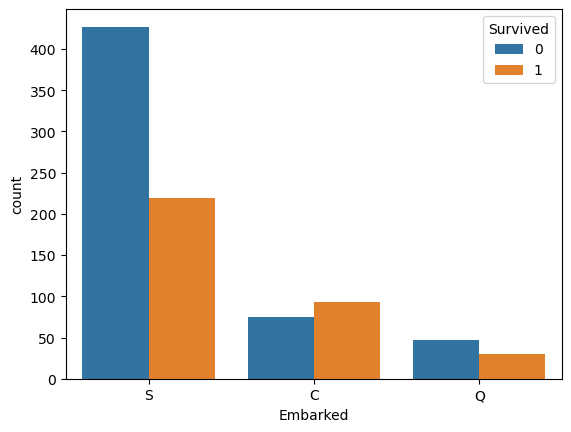

In [623]:
sns.countplot(data = train, x = 'Embarked', hue = 'Survived')
plt.show()

In [624]:
# S 승선항에서 Pclass가 3인 사람이 많이 타지 않았을까??

- 승선항과 Pclass의 관계 시각화

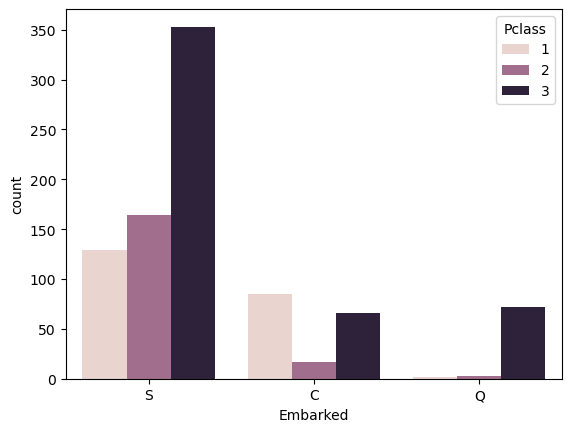

In [626]:
sns.countplot(data = train, x = 'Embarked', hue = 'Pclass')
plt.show()

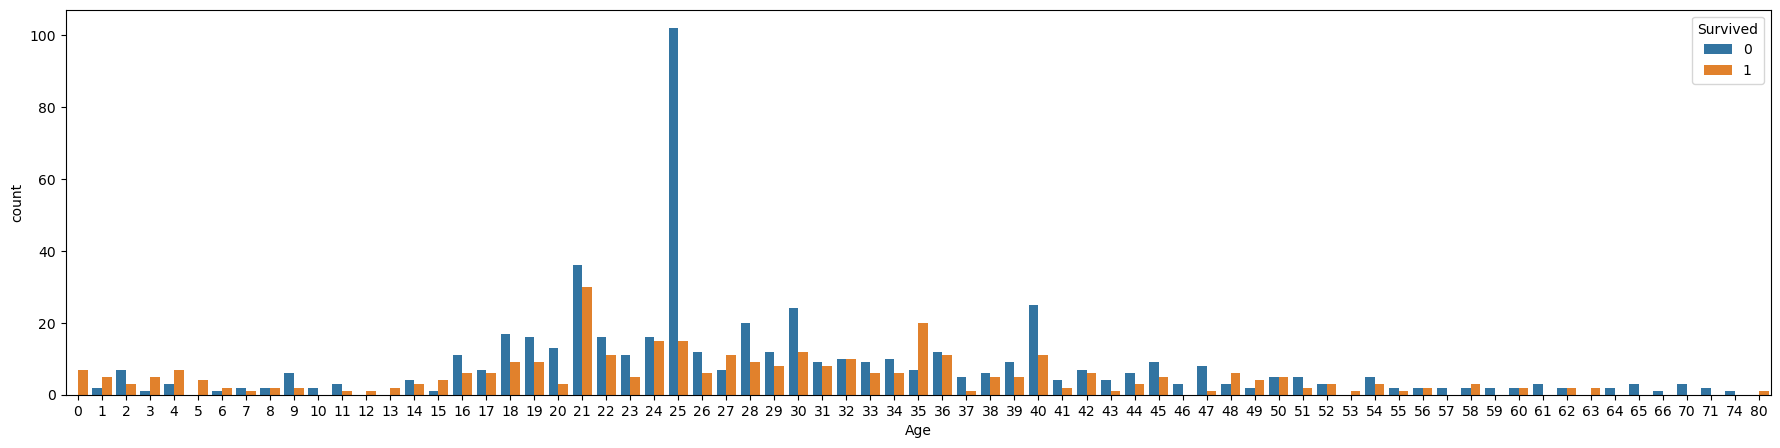

In [627]:
plt.figure(figsize=(22,5))
sns.countplot(data = train, x = 'Age', hue = 'Survived')
plt.show()

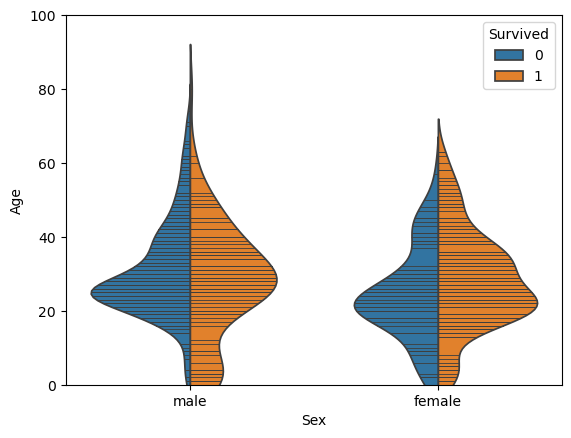

In [628]:
# 나이데이터를 시각화 했더니, 해석하기 어려움 >> 바이올린 플롯으로 변경
# violinplot : 수치형 데이터의 분포를 확인할 때 사용하는 그래프
# 데이터가 많은쪽은 두껍게, 적은쪽은 얇게

sns.violinplot(data = train,
               x = 'Sex',
               y = 'Age',
               hue = 'Survived',
              split = True, # 데이터를 양쪽에 나눠서 표현
              inner = 'stick' # 바이올린 내부에 개별 데이터선
              )
plt.ylim(0,100)
plt.show()

In [629]:
# Sex와 Fare에 따른 Survived 시각화

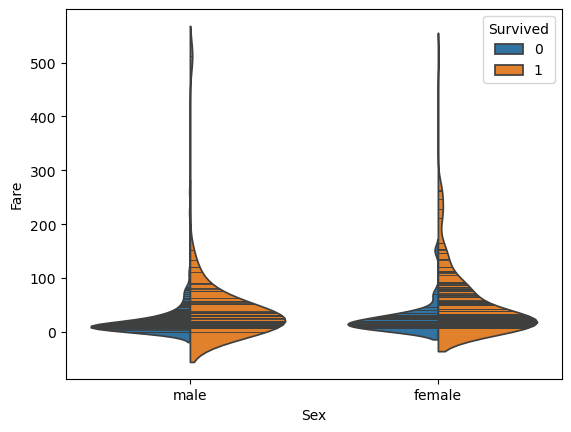

In [630]:
sns.violinplot(data = train,
               x = 'Sex',
               y = 'Fare',
               hue = 'Survived',
              split = True, # 데이터를 양쪽에 나눠서 표현
              inner = 'stick' # 바이올린 내부에 개별 데이터선
              )

plt.show()

In [631]:
# 성별 불문, 요금이 저렴한 사람들의 사망률이 높았다.

- 특성공학 : 새로운 컬럼 생성(transform)
- Parch, SibSp를 더해서 가족의 숫자라는 새로운 컬럼 생성
- train, test 동일하게.

In [633]:
# train
train['Family_size'] = train['Parch'] + train['SibSp'] + 1 # 본인 포함 가족 구성원의 수
train['Family_size']

PassengerId
1      2
2      2
3      1
4      2
5      1
      ..
887    1
888    1
889    4
890    1
891    1
Name: Family_size, Length: 891, dtype: int64

In [634]:
# test
test['Family_size'] = test['Parch'] + test['SibSp'] + 1 # 본인 포함 가족 구성원의 수
test['Family_size']

PassengerId
892     1
893     2
894     1
895     1
896     3
       ..
1305    1
1306    1
1307    1
1308    1
1309    3
Name: Family_size, Length: 418, dtype: int64

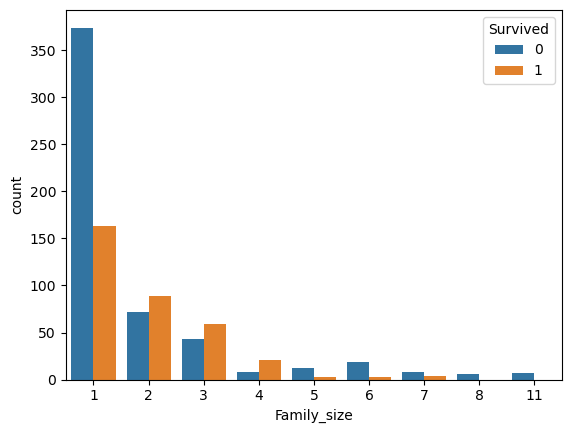

In [635]:
# 시각화
sns.countplot(data = train, x = 'Family_size', hue = 'Survived')
plt.show()

In [636]:
# 1명일 경우, 사망률이 높다. -alone
# 2~4명일 경우, 생존율이 높다. -small
# 5명 이상일경우, 사망률이 높다. -large

- Family_size가 1이면 Alone, 2~4이면 Small, 5명이상이면 Large로 바꿔줌
- train, test 동일

In [638]:
bins = [0,1,4,11]
# (0, 1] > 0초과 1이하
# (1, 4] > 1초과 4이하
# (4, 11] > 4초과 11이하

labels = ['Alone', 'Small', 'Large']

# cut : 연속적인 수치형 데이터를 일정 범위로 나누어줌 > 범주형으로.
train['Family_group'] = pd.cut(train['Family_size'], bins = [0, 1, 4, 11], labels = labels)

In [639]:
# test 데이터도 binning
test['Family_group'] = pd.cut(test['Family_size'], bins = [0, 1, 4, 11], labels = labels)

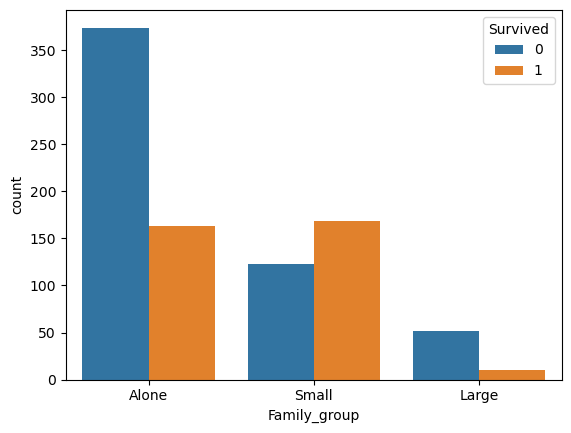

In [640]:
sns.countplot(
    data = train,
    x = 'Family_group',
    hue = 'Survived')
plt.show()

- 불필요한 컬럼 삭제
- .drop() 사용
- 전처리 대상에서 제외된 컬럼과 특성공학 후 불필요해진 컬럼 삭제.

In [642]:
train.info()
# 삭제 대상은 전처리 후 필요없어진 컬럼, 전처리하지 않은 컬럼중 불필요한 컬럼.
# Name, SibSp, Parch, Ticket, Family_size

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Name          891 non-null    object  
 3   Sex           891 non-null    object  
 4   Age           891 non-null    int64   
 5   SibSp         891 non-null    int64   
 6   Parch         891 non-null    int64   
 7   Ticket        891 non-null    object  
 8   Fare          891 non-null    float64 
 9   Embarked      891 non-null    object  
 10  Deck          891 non-null    object  
 11  Family_size   891 non-null    int64   
 12  Family_group  891 non-null    category
dtypes: category(1), float64(1), int64(6), object(5)
memory usage: 91.5+ KB


In [643]:
# Name, SibSp, Parch, Ticket, Family_size 삭제
train.drop(['Name','SibSp','Parch','Ticket','Family_size'], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    object  
 3   Age           891 non-null    int64   
 4   Fare          891 non-null    float64 
 5   Embarked      891 non-null    object  
 6   Deck          891 non-null    object  
 7   Family_group  891 non-null    category
dtypes: category(1), float64(1), int64(3), object(3)
memory usage: 56.7+ KB


In [644]:
test.drop(['Name','SibSp','Parch','Ticket','Family_size'], axis = 1, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    object  
 2   Age           418 non-null    int64   
 3   Fare          418 non-null    float64 
 4   Embarked      418 non-null    object  
 5   Deck          418 non-null    object  
 6   Family_group  418 non-null    category
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 23.4+ KB


- train에는 정답데이터와 문제데이터가 하나의 프레임으로 들어가있는 상태(X_train, y_train)
- test에는 정답데이터가 없음. (X_test)

In [646]:
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']
X_test = test

print(X_train.shape, y_train.shape, X_test.shape)

(891, 7) (891,) (418, 7)


- 범주형 데이터는 학습용으로 사용할 수 없으니, 수치형 변환
- Encoding
- One-Hot encoding > 구분 용도를 위해서.

In [648]:
X_train_one_hot = pd.get_dummies(X_train)
X_test_one_hot = pd.get_dummies(X_test)

In [649]:
X_train_one_hot

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Family_group_Alone,Family_group_Small,Family_group_Large
PassengerId,,,,,,,,,,,,,,,,,,,,
1,3,22,7.2500,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False
2,1,38,71.2833,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,3,26,7.9250,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
4,1,35,53.1000,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False
5,3,35,8.0500,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,27,13.0000,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
888,1,19,30.0000,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False
889,3,21,23.4500,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False


In [650]:
X_test_one_hot

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Family_group_Alone,Family_group_Small,Family_group_Large
PassengerId,,,,,,,,,,,,,,,,,,,
892,3,34,7.8292,False,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False
893,3,47,7.0000,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
894,2,62,9.6875,False,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False
895,3,27,8.6625,False,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False
896,3,22,12.2875,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,25,8.0500,False,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False
1306,1,39,108.9000,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False
1307,3,38,7.2500,False,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False


In [651]:
X_train_one_hot.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'Family_group_Alone',
       'Family_group_Small', 'Family_group_Large'],
      dtype='object')

In [652]:
X_test_one_hot.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Family_group_Alone',
       'Family_group_Small', 'Family_group_Large'],
      dtype='object')

- 특성 개수 맞추기
- 부족한 컬럼명을 확인
- set() 집합 자료구조 활용 찾아보기.

In [654]:
# set이라는 데이터 타입(집합 자료형)
set(X_train_one_hot.columns) - set(X_test_one_hot.columns)

{'Deck_T'}

In [655]:
# X_test에 Deck_T 컬럼 추가
X_test_one_hot['Deck_T'] = 0
X_test_one_hot['Deck_T']

PassengerId
892     0
893     0
894     0
895     0
896     0
       ..
1305    0
1306    0
1307    0
1308    0
1309    0
Name: Deck_T, Length: 418, dtype: int64

In [656]:
X_train_one_hot.info()
X_test_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              891 non-null    int64  
 1   Age                 891 non-null    int64  
 2   Fare                891 non-null    float64
 3   Sex_female          891 non-null    bool   
 4   Sex_male            891 non-null    bool   
 5   Embarked_C          891 non-null    bool   
 6   Embarked_Q          891 non-null    bool   
 7   Embarked_S          891 non-null    bool   
 8   Deck_A              891 non-null    bool   
 9   Deck_B              891 non-null    bool   
 10  Deck_C              891 non-null    bool   
 11  Deck_D              891 non-null    bool   
 12  Deck_E              891 non-null    bool   
 13  Deck_F              891 non-null    bool   
 14  Deck_G              891 non-null    bool   
 15  Deck_M              891 non-null    bool   
 16  Deck_T       

In [657]:
X_train_one_hot.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'Family_group_Alone',
       'Family_group_Small', 'Family_group_Large'],
      dtype='object')

In [658]:
# X_train과 X_test의 컬럼 순서가 다르다.
# X_train 컬럼의 순서로 맞춰준다.
X_test_one_hot = X_test_one_hot[X_train_one_hot.columns]

In [659]:
print(X_train_one_hot.shape, y_train.shape)
print(X_test_one_hot.shape)

(891, 20) (891,)
(418, 20)


------- 06/12

#### 모델 선택 및 학습

In [662]:
# 필요한 라이브러리 가져오기
from sklearn.tree import DecisionTreeClassifier
# 교차검증 라이브러리
from sklearn.model_selection import cross_val_score

In [773]:
# 모델 객체 생성
tree_model = DecisionTreeClassifier()

In [789]:
# 교차 검증
cv_result = cross_val_score(tree_model, X_train_one_hot, y_train, cv = 5) # cv : 교차검증 횟수.
cv_result

array([0.81005587, 0.80898876, 0.80337079, 0.78089888, 0.8258427 ])

In [777]:
cv_result.mean() # 평균 78%, 평가 데이터에서는 정확도가 떨어질 수 있다.

0.7946519364760529

- tree model의 하이퍼 파라미터 조정

In [783]:
tree_model = DecisionTreeClassifier(max_depth = 3)

In [785]:
result = cross_val_score(tree_model, X_train_one_hot, y_train, cv = 5)
result

array([0.81005587, 0.81460674, 0.80337079, 0.78089888, 0.8258427 ])

In [791]:
result.mean() # 80%로 성능 향상. > 과대적합이 해결되면서 성능이 향상함.

0.8069549934090766

In [809]:
# 교차검증을 하면서 하이퍼파라미터 조정 확인 (1~9)
for md in range(1,10):
    tree_model = DecisionTreeClassifier(max_depth = md)
    result = cross_val_score(tree_model, X_train_one_hot, y_train, cv = 5)
    # print(result.mean())
    print(f'depth : {md}', result.mean())

depth : 1 0.7867365513778168
depth : 2 0.773316176009039
depth : 3 0.8058313979034587
depth : 4 0.8092524009792228
depth : 5 0.8148138848785387
depth : 6 0.815956311593748
depth : 7 0.8058439520431863
depth : 8 0.8181846713953927
depth : 9 0.8024982738057874


In [815]:
# 하이퍼파라미터 8일때에 정확도가 가장 높다 81.8% : max_depth : 8
tree_model2 = DecisionTreeClassifier(max_depth = 6)

# 학습
tree_model2.fit(X_train_one_hot, y_train)

# 예측값
pred_tree = tree_model2.predict(X_test_one_hot)

# 모델 답안지 작성 - tree_model_(number).csv
result2 = pd.read_csv('./data/gender_submission.csv')
result2['Survived'] = pred_tree
result2.to_csv('./data/tree_model_02.csv', index = False)

In [825]:
# tree_model2 가 어떤 특성을 중요하게 생각하는지 특성 중요도 확인
fi = tree_model2.feature_importances_
fi

array([0.12587444, 0.11648766, 0.08001609, 0.50258411, 0.        ,
       0.00301714, 0.        , 0.0083284 , 0.        , 0.        ,
       0.00403921, 0.        , 0.01510388, 0.        , 0.        ,
       0.05694591, 0.        , 0.        , 0.0470039 , 0.04059924])

In [837]:
fi_s = pd.DataFrame(fi, index = X_train_one_hot.columns, columns = ['imp'])
fi_s

,imp
Pclass,0.125874
Age,0.116488
Fare,0.080016
Sex_female,0.502584
Sex_male,0.000000
Embarked_C,0.003017
Embarked_Q,0.000000
Embarked_S,0.008328
Deck_A,0.000000
Deck_B,0.000000


<Figure size 500x500 with 0 Axes>

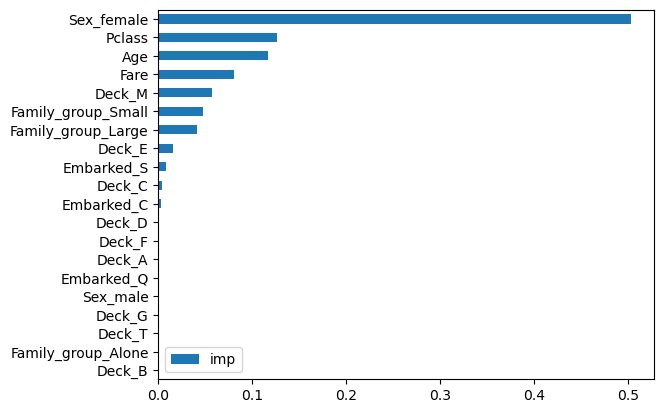

In [851]:
plt.figure(figsize = (5,5))
fi_s.sort_values('imp', ascending = True).plot.barh()
plt.show()

### 앙상블
- 여러 모델을 결합하는 방식으로 성능을 올리는 기법
1. 보팅(Voting)
   - 여러 다른 종류의 모델이 예측한 결과를 투표(분류) 혹은 평균(회귀)을 통해 최종 결정
     A. 하드보팅(Hard-Voting) : 다수결
     B. 소프트보팅(Soft-Voting) : 확률값을 통한 결정
2. 배깅(Bagging)
   - 여러 같은 종류의 모델이 예측한 결과를 투표(분류) 혹은 평균(회귀)을 통해 최종 결정
     A. RandomForest (Decision Tree를 여러개 사용하는 모델)
3. 부스팅(Boosting)
   - 여러 모델이 순차적으로 학습-예측하며 잘못 예측한 데이터에 가중치를 부여해 오류를 개선해나가면서 학습하는 방식
     - AdaBoost, GradientBoost, eXtremeGradientBoost, LightGradientBoost
     - 후속 모델이 이전 모델의 잘못된 예측을 수정하면서 성능이 점점 좋아지는 방식

In [929]:
# 필요한 라이브러리 불러오기
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

### 랜덤포레스트

In [858]:
forest_model = RandomForestClassifier(n_estimators = 100, # 트리의 개수
                                     max_features = 5, # 각각의 트리가 선택할 특성개수의 최대
                                     max_depth = 4,
                                     random_state =1)

In [860]:
# 랜덤포레스트 모델 교차검증
result_RF = cross_val_score(forest_model,
                            X_train_one_hot,
                            y_train,
                            cv = 5)
result_RF

array([0.82681564, 0.82022472, 0.80898876, 0.79775281, 0.84269663])

In [862]:
result_RF.mean()

0.819295712761283

#### 에이다 부스팅

In [867]:
ada_model = AdaBoostClassifier(n_estimators = 100,
                              random_state = 1)

In [869]:
result_ada = cross_val_score(ada_model,
                             X_train_one_hot,
                             y_train,
                             cv = 5)
result_ada

C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\sit

array([0.77653631, 0.81460674, 0.80898876, 0.8258427 , 0.83707865])

In [871]:
result_ada.mean()

0.8126106333563493

### 보팅

In [925]:
voting_model = VotingClassifier(estimators = [('tree1',tree_model2),
                                             ('forest',forest_model),
                                             ('ada',ada_model)],
                                voting = 'soft'
                                )

In [927]:
result_voting = cross_val_score(voting_model,
                                X_train_one_hot,
                                y_train,
                                cv = 5)
result_voting

C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\a\anaconda3\Lib\sit

array([0.81005587, 0.80337079, 0.83146067, 0.80898876, 0.84269663])

In [880]:
result_voting.mean()

0.8204318624066286

XGBoost, LightGBM

In [889]:
# xgboost 설치
!pip install xgboost

In [891]:
# light gbm 설치
!pip install lightgbm

In [893]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [895]:
xg_model = XGBClassifier(n_estimators = 100,
                         random_state = 1)

In [901]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 891 entries, 1 to 891
Series name: Survived
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 13.9 KB


In [913]:
result_xg = cross_val_score(xg_model,
                                X_train_one_hot,
                                y_train,
                                cv = 5)
result_xg

array([0.79329609, 0.80898876, 0.84831461, 0.79775281, 0.85393258])

In [915]:
result_xg.mean()

0.8204569706860838

LightGBM

In [918]:
light_model = LGBMClassifier(n_estimators = 100,
                             random_state = 1)

In [920]:
result_light = cross_val_score(light_model,
                                X_train_one_hot,
                                y_train,
                                cv = 5)
result_light

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

array([0.79888268, 0.81460674, 0.86516854, 0.80337079, 0.87078652])

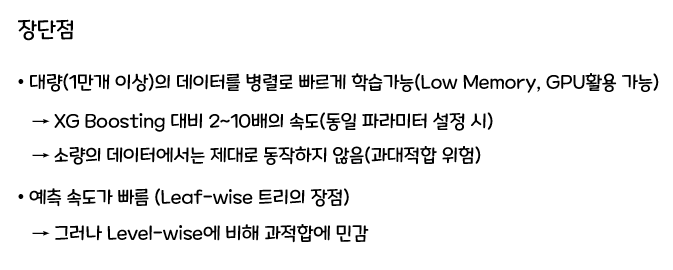

In [922]:
result_light.mean()

0.8305630531667818

In [931]:
tree_model3 = DecisionTreeClassifier(max_depth = 6)

tree_model4 =  DecisionTreeClassifier(max_depth = 4)

tree_model5 =  DecisionTreeClassifier(max_depth = 7)

tree_model6 =  DecisionTreeClassifier(max_depth = 11)

In [958]:
# 하이퍼파라미터 8일때에 정확도가 가장 높다 81.8% : max_depth : 8
Bagging_model = BaggingClassifier(estimator=tree_model, max_features=20, n_estimators=10, random_state=42
                                )

# 학습
Bagging_model.fit(X_train_one_hot, y_train)

# 예측값
pred_tree = Bagging_model.predict(X_test_one_hot)

# 모델 답안지 작성 - tree_model_(number).csv
result2 = pd.read_csv('./data/gender_submission.csv')
result2['Survived'] = pred_tree
result2.to_csv('./data/Bagging_model_02.csv', index = False)

In [ ]:
voting_model2 = VotingClassifier(estimators = [('tree1',tree_model2),
                                             ('forest',forest_model),
                                              ('tree2',tree_model3),
                                             ('ada',ada_model)],
                                voting = 'soft'
                                )

In [946]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100, max_depth=8, random_state=42)
xgb.fit(X_train_one_hot, y_train)
pred_xgb = xgb.predict(X_test_one_hot)
pred_xgb

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [948]:
pred_xgb = pd.read_csv('./data/gender_submission.csv')
pred_xgb['Survived'] = pred_tree
pred_xgb.to_csv('./data/xgb_model_01.csv', index = False)